In [2]:
import numpy as np
import pandas as pd

In [3]:
#Импортируем данные и выявим требования к задаче

df = pd.read_csv('worldcities.csv')
df

,lat,lng,country,target
0,35.6850,139.7514,Japan,0
1,40.6943,-73.9249,United States,1
2,19.4424,-99.1310,Mexico,0
3,19.0170,72.8570,India,0
4,-23.5587,-46.6250,Brazil,0
...,...,...,...,...
15488,62.5333,-42.2167,Greenland,0
15489,51.3894,30.0989,Ukraine,0
15490,69.6510,162.3336,Russia,0
15491,74.0165,111.5100,Russia,0


In [4]:
unique_classes = df['target'].value_counts()

In [5]:
unique_classes

#На основании этого делаем вывод, что нам нужно построить нейросеть, которая сможет с требуемой точностью выполнять бинарную классификацию

target
0    8165
1    7328
Name: count, dtype: int64

In [6]:
df.isnull().sum()

#Проверили на пропуски, данные буквально готовы к формированию тренировочного и тестового датасета для нейросети.

lat        0
lng        0
country    0
target     0
dtype: int64

In [7]:
# Напишем базовую архитектуру: многослойный персептрон 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class DeepMLP(nn.Module):
    def __init__(self):
        super(DeepMLP, self).__init__()
        self.fc1 = nn.Linear(2, 64)  # Предполагается, что у нас 2 входных признака: широта и долгота
        self.fc2 = nn.Linear(64, 64) #Hidden Layer
        self.fc3 = nn.Linear(64, 1) #Output layer; 1 выход, осуществляющий бинарную классификацию

    def forward(self, x): # Метод для прямого распространения (нейронное прогнозирование)
        x = F.relu(self.fc1(x)) # Функция активации на первом слое
        x = F.relu(self.fc2(x)) # Функция активации на скрытом слое
        x = torch.sigmoid(self.fc3(x))  # Сигмоидная функция активации на выходном слое для бинарной классификации
        return x

In [8]:
model = DeepMLP() #Создаём экземпляр модельки (персептрона)

In [9]:
# Определение функции потерь и оптимизатора
criterion = nn.BCELoss()  # Binary Cross Entropy Loss (функция потерь)
optimizer = optim.Adam(model.parameters(), lr=0.001) #Алгоритм, который будет обновлять наши веса с той степенью небрежности, что указана в learning rate, руководствуясь вычисленными градиентами. 

In [11]:
# Для начала разделим данные на признаки и классовые метки 
X = df[['lat', 'lng']]  # Признаки: широта и долгота
y = df['target']  # Метка: принадлежности к классу

# Теперь разделим данные на тренировочный и тестовый датасеты
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset

# Сначала разделим данные на тренировочные (80%) и тестовые (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Теперь разделим тренировочные данные на тренировочные (80%) и валидационные (20%)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Проверим размеры полученных датасетов
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

# Преобразование данных в тензоры PyTorch
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Создание наборов данных для PyTorch
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Создание DataLoader'ов для тренировочных, валидационных и тестовых наборов данных
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

(9915, 2) (2479, 2) (3099, 2) (9915,) (2479,) (3099,)


In [12]:
from tqdm import tqdm 

In [13]:
# Обучение модели
num_epochs = 500  # Кол-во проходов по всему датасету

for epoch in tqdm(range(num_epochs), desc='Training epochs'):
    for inputs, labels in train_loader: #итерируемся по признакам и меткам
        optimizer.zero_grad()  # Обнуление градиентов
        outputs = model(inputs)  # Прямой проход, нейронное прогнозирование
        loss = criterion(outputs, labels.view(-1, 1))  # Вычисление потерь, в результате прогноза 
        loss.backward()  # Обратное распространение для вычисления градиентов (механики изменения функции потер, 
        # в результате изменения её аргумента - весов)
        optimizer.step()  # Обновление весов оптимизатором, на основе подсчитанных градиентов

# После обучения, модели можно использовать для предсказания и оценки точности

Training epochs: 100%|██████████| 500/500 [00:38<00:00, 13.04it/s]


In [14]:
#Валидация модели в виде функции (вызываемого метода)

model.eval()  # Переключение модели в режим оценки
total_val_loss = 0
total_val_samples = 0

with torch.no_grad():  # Отключение вычисления градиентов для валидации
    for inputs, labels in val_loader:
        outputs = model(inputs)
        val_loss = criterion(outputs, labels.view(-1, 1))
        total_val_loss += val_loss.item() * inputs.size(0)
        total_val_samples += inputs.size(0)

average_val_loss = total_val_loss / total_val_samples
print(f"Validation Loss: {average_val_loss:.4f}")

Validation Loss: 0.0159


In [15]:
from sklearn.metrics import confusion_matrix

# Теперь мы вычислим предсказания на тренировочном наборе данных
model.eval()  # Переключаем модель в режим оценки
with torch.no_grad():  # Отключаем вычисление градиентов
    outputs = model(X_test_tensor)
    predictions = outputs.round()  # Округляем выходные данные для получения бинарных предсказаний

# Преобразуем предсказания и истинные метки в формат NumPy для использования в sklearn
y_pred_np = predictions.numpy()
y_test_np = y_test_tensor.numpy()

# Вычисляем матрицу ошибок
conf_matrix = confusion_matrix(y_test_np, y_pred_np)
TP = conf_matrix[1, 1]
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]

# Вычисляем чувствительность и специфичность
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

# Вычисляем метрику p
p = (sensitivity + specificity) / 2
print(f"Sensitivity: {sensitivity}, Specificity: {specificity}, p: {p}")

Sensitivity: 0.9972202918693537, Specificity: 0.9885542168674699, p: 0.9928872543684117


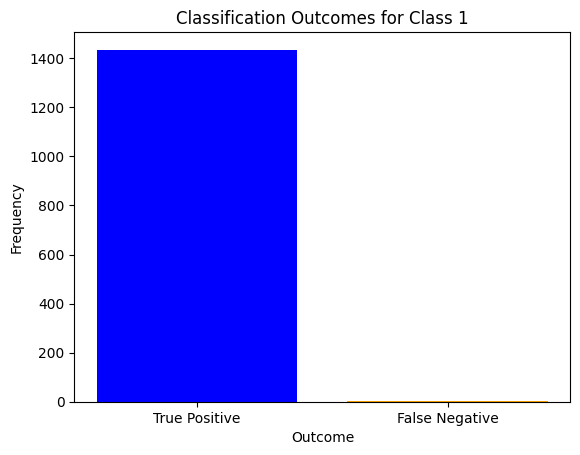

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Предположим, что y_test_np - это истинные метки классов, а y_pred_np - предсказанные моделью
conf_matrix = confusion_matrix(y_test_np, y_pred_np)
TP = conf_matrix[1, 1]
FN = conf_matrix[1, 0]

# Создание диаграммы
labels = ['True Positive', 'False Negative']
values = [TP, FN]

plt.bar(labels, values, color=['blue', 'orange'])
plt.title('Classification Outcomes for Class 1')
plt.xlabel('Outcome')
plt.ylabel('Frequency')
plt.show()

In [17]:
#Вычислим размер нейросети

# Исходная архитектура сети
n_inputs = 2
n_hidden1 = 64
n_hidden2 = 64
n_outputs = 1

# Вычисление количества умножений для исходной архитектуры
total_multiplications = (n_inputs * n_hidden1) + (n_hidden1 * n_hidden2) + (n_hidden2 * n_outputs)

print(total_multiplications)

4288


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Определение архитектуры модели
class CompressedMLP(nn.Module):
    def __init__(self):
        super(CompressedMLP, self).__init__()
        self.fc1 = nn.Linear(2, 32) 
        self.fc2 = nn.Linear(32, 32) 
        self.fc3 = nn.Linear(32, 1) 

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x)) 
        return x

In [19]:
Compressed_model = CompressedMLP()

In [20]:
# Определение функции потерь и оптимизатора
criterion2 = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer2 = optim.Adam(Compressed_model.parameters(), lr=0.001) #Алгоритм, который будет обновлять наши веса с той степенью небрежности, что указана в learning rate, руководствуясь вычисленными градиентами (механики изменения нашей потери, в результате изменения коэффициента веса)

In [21]:
# Обучение сжатой модели
num_epochs = 500  

for epoch in tqdm(range(num_epochs), desc='Training epochs'):
    for inputs, labels in train_loader:
        optimizer2.zero_grad()  
        outputs = Compressed_model(inputs)  
        loss = criterion2(outputs, labels.view(-1, 1)) 
        loss.backward()  
        optimizer2.step()  

Training epochs: 100%|██████████| 500/500 [00:36<00:00, 13.63it/s]


In [23]:
#Валидация уже сжатой модели в виде функции (вызываемого метода)

Compressed_model.eval()  # Переключение модели в режим оценки
total_val_loss2 = 0
total_val_samples2 = 0

with torch.no_grad():  # Отключение вычисления градиентов для валидации
    for inputs, labels in val_loader:
        outputs = Compressed_model(inputs)
        val_loss2 = criterion(outputs, labels.view(-1, 1))
        total_val_loss2 += val_loss.item() * inputs.size(0)
        total_val_samples2 += inputs.size(0)

average_val_loss2 = total_val_loss2 / total_val_samples2
print(f"Validation Loss: {average_val_loss2:.4f}")

Validation Loss: 0.0170


In [25]:
# Теперь мы вычислим предсказания на тестовом наборе данных
Compressed_model.eval()  # Переключаем модель в режим оценки
with torch.no_grad():  # Отключаем вычисление градиентов
    outputs = Compressed_model(X_test_tensor)
    predictions = outputs.round()  # Округляем выходные данные для получения бинарных предсказаний

# Преобразуем предсказания и истинные метки в формат NumPy для использования в sklearn
y_pred_np2 = predictions.numpy()
y_test_np2 = y_test_tensor.numpy()

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Вычисляем матрицу ошибок
conf_matrix2 = confusion_matrix(y_test_np2, y_pred_np2)
TP = conf_matrix2[1, 1]
TN = conf_matrix2[0, 0]
FP = conf_matrix2[0, 1]
FN = conf_matrix2[1, 0]

# Вычисляем чувствительность и специфичность
sensitivity2 = TP / (TP + FN)
specificity2 = TN / (TN + FP)

# Вычисляем метрику p
p2 = (sensitivity2 + specificity2) / 2
print(f"Sensitivity: {sensitivity2}, Specificity: {specificity2}, p: {p2}")

Sensitivity: 0.9979152189020153, Specificity: 0.9825301204819277, p: 0.9902226696919715


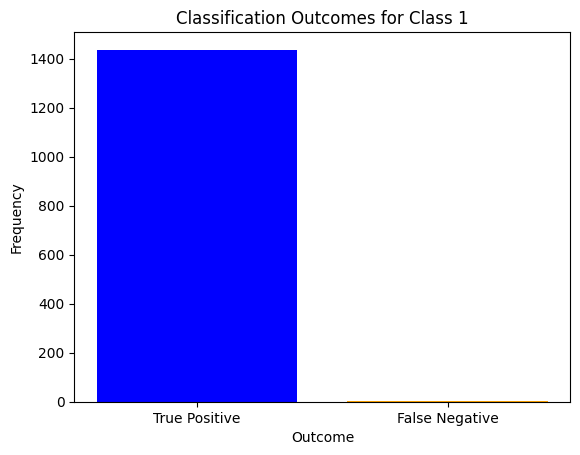

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Предположим, что y_test_np - это истинные метки классов, а y_pred_np - предсказанные моделью
conf_matrix2 = confusion_matrix(y_test_np2, y_pred_np2)
TP = conf_matrix2[1, 1]
FN = conf_matrix2[1, 0]

# Создание диаграммы
labels = ['True Positive', 'False Negative']
values = [TP, FN]

plt.bar(labels, values, color=['blue', 'orange'])
plt.title('Classification Outcomes for Class 1')
plt.xlabel('Outcome')
plt.ylabel('Frequency')
plt.show()

In [37]:
#Вычислим размер сжатой нейросети

# Исходная архитектура сети
n2_inputs = 2
n2_hidden1 = 32
n2_hidden2 = 32
n2_outputs = 1

# Вычисление количества умножений для сжатой архитектуры
total_multiplications2 = (n2_inputs * n2_hidden1) + (n2_hidden1 * n2_hidden2) + (n2_hidden2 * n2_outputs)

print(total_multiplications2)

1120


In [46]:
compressed_ratio = total_multiplications/total_multiplications2 # во сколько раз уменьшили нейросеть

delta_p = p2 - p #изменения в метрике P

delta_multiplications = total_multiplications - total_multiplications2

delta_p_rounded = round(delta_p, 4)
compressed_ratio_rounded = round(compressed_ratio, 3)

print(delta_p_rounded)
print(compressed_ratio_rounded)

p2_rounded = round(p2, 4)
print(p2_rounded)

-0.0027
3.829
0.9902


In [48]:
print(f'Нам удалось сжать нейросеть в {compressed_ratio_rounded} раз буквально не потеряв в точности, наша потеря в метрике P составила {delta_p_rounded}')

print(f'Первоначальное число нейронов составило {total_multiplications}, однако мы сократили до {total_multiplications2}, избавившись от {delta_multiplications} нейронов, максимально приблизившись до пограничной точности равной {p2_rounded}')

Нам удалось сжать нейросеть в 3.829 раз буквально не потеряв в точности, наша потеря в метрике P составила -0.0027
Первоначальное число нейронов составило 4288, однако мы сократили до 1120, избавившись от 3168 нейронов, максимально приблизившись до пограничной точности равной 0.9902
